In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

# torch library

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot

In [22]:
# # warning表示off
# import warnings
# warnings.simplefilter('ignore')

# # デフォルトフォントサイズ変更
# plt.rcParams['font.size'] = 14

# # デフォルトグラフサイズ変更
# plt.rcParams['figure.figsize'] = (6,6)

# # デフォルトで方眼表示ON
# plt.rcParams['axes.grid'] = True

# # numpyの表示桁数設定
# np.set_printoptions(suppress=True, precision=5)

In [23]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [24]:
import torchvision.datasets as datasets

# data direct
data_root = './data'

train_set0 = datasets.MNIST(
    root = data_root,  
    train = True,  
    download = True)

In [25]:
import torchvision.transforms as transforms

# データ変換用関数 Transforms

transform = transforms.Compose([
    # (1) to tensor
    transforms.ToTensor(),
    
    # (2) normalize
    transforms.Normalize(0.5, 0.5),
    
    # (3) to 1 tensor
    transforms.Lambda(lambda x: x.view(-1)),
])

In [26]:
# データ取得用関数 Dataset

# train data
train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform)

# test data
test_set = datasets.MNIST(
    root = data_root, train = False, 
    download = True, transform = transform)

In [27]:
from torch.utils.data import DataLoader

# batch size
batch_size = 100

# train dataloader with shuffle
train_loader = DataLoader(
    train_set, batch_size = batch_size, 
    shuffle = True)

# test dataloader
test_loader = DataLoader(
    test_set,  batch_size = batch_size, 
    shuffle = False)

In [28]:
############提出時不要##################3
# 何組のデータが取得できるか
print(len(train_loader))

# DataLoaderから最初の1セットを取得する
for images, labels in train_loader:
    break

print(images.shape)
print(labels.shape)

600
torch.Size([100, 784])
torch.Size([100])


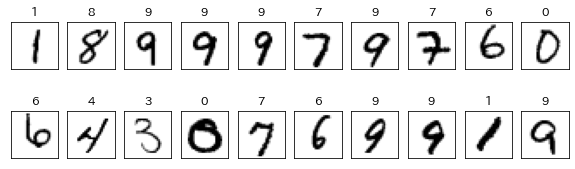

In [29]:
############提出時不要##################3
# イメージ表示
plt.figure(figsize=(10, 3))
for i in range(20):
    ax = plt.subplot(2, 10, i + 1)
    
    # numpyに変換
    image = images[i].numpy()
    label = labels[i]
    
    # imgの範囲を[0, 1]に戻す
    image2 = (image + 1)/ 2
    # イメージ表示
    plt.imshow(image2.reshape(28, 28),cmap='gray_r')
    ax.set_title(f'{label}')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [30]:
# deg of input
n_input = image.shape[0]

# deg of output
# the num of classes
n_output = len(set(list(labels.data.numpy())))

#   # of hidden node
n_hidden = 50

# print hyperparameters
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 784  n_hidden: 50 n_output: 10


In [31]:
# model
# in: 784 out:10 hidden: 1 layer

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # hidden
        self.l1 = nn.Linear(n_input, n_hidden)

        # Sigmoid
        self.sigmoid = nn.Sigmoid()
        
        # output
        self.l2 = nn.Linear(n_hidden, n_output)


   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.sigmoid(x1)
        x3 = self.l2(x2)
        return x3

In [32]:
# model instance
net = Net(n_input, n_output, n_hidden).to(device)

# loss function: cross entropy
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(net.parameters(), lr=0.1)

# epoch
num_epochs = 30

# record result
history = np.zeros((0,5))

In [33]:
# loop

for epoch in range(num_epochs):
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_test = 0, 0

    # training
    for inputs, labels in train_loader:
        n_train += len(labels)

        # device
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # init grad
        optimizer.zero_grad()

        # calc output
        outputs = net(inputs)

        # calc loss
        loss = criterion(outputs, labels)

        # grad backward
        loss.backward()
    
        # modify parameters
        optimizer.step()

        # predict labels
        predicted = torch.max(outputs, 1)[1]

        # calc loss and accuracy
        train_loss += loss.item()
        train_acc += (predicted == labels).sum() 

    # predict
    for inputs_test, labels_test in test_loader:
        n_test += len(labels_test)

        inputs_test = inputs_test.to(device)
        labels_test = labels_test.to(device)

            
        # calc output
        outputs_test = net(inputs_test)

        # calc loss
        loss_test = criterion(outputs_test, labels_test)

        # output pred
        predicted_test = torch.max(outputs_test, 1)[1]

        # calc loss and accu
        val_loss +=  loss_test.item()
        val_acc +=  (predicted_test == labels_test).sum()

    # calc metrics and recode them
    train_acc = train_acc / n_train
    val_acc = val_acc / n_test
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_test
    print (f'Epoch [{epoch+1}/{num_epochs}], loss: {train_loss:.5f} acc: {train_acc:.5f} val_loss: {val_loss:.5f}, val_acc: {val_acc:.5f}')
    item = np.array([epoch+1 , train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

Epoch [1/30], loss: 0.83449 acc: 0.80715 val_loss: 0.40612, val_acc: 0.89760
Epoch [2/30], loss: 0.35901 acc: 0.90100 val_loss: 0.31066, val_acc: 0.91330
Epoch [3/30], loss: 0.29826 acc: 0.91522 val_loss: 0.26671, val_acc: 0.92560
Epoch [4/30], loss: 0.26557 acc: 0.92313 val_loss: 0.24300, val_acc: 0.93080
Epoch [5/30], loss: 0.24205 acc: 0.93067 val_loss: 0.22664, val_acc: 0.93530
Epoch [6/30], loss: 0.22357 acc: 0.93657 val_loss: 0.21512, val_acc: 0.93750
Epoch [7/30], loss: 0.20786 acc: 0.94098 val_loss: 0.19940, val_acc: 0.94170
Epoch [8/30], loss: 0.19527 acc: 0.94457 val_loss: 0.18868, val_acc: 0.94550
Epoch [9/30], loss: 0.18330 acc: 0.94798 val_loss: 0.18054, val_acc: 0.94780
Epoch [10/30], loss: 0.17343 acc: 0.95040 val_loss: 0.17292, val_acc: 0.94880
Epoch [11/30], loss: 0.16409 acc: 0.95383 val_loss: 0.16623, val_acc: 0.95120
Epoch [12/30], loss: 0.15683 acc: 0.95538 val_loss: 0.16091, val_acc: 0.95290
Epoch [13/30], loss: 0.14955 acc: 0.95777 val_loss: 0.15358, val_acc: 0.9

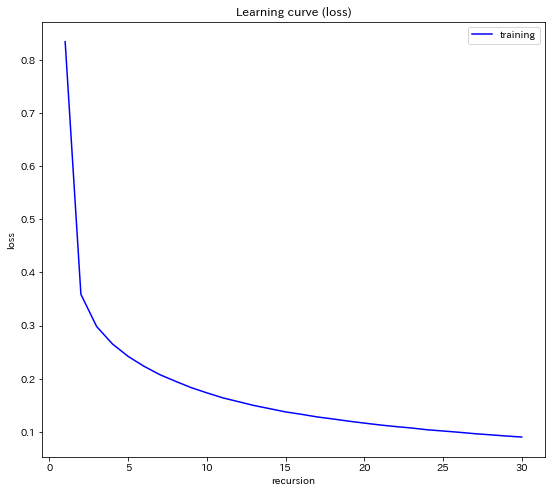

In [38]:
# learning curve
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], history[:,1], 'b', label='training')
plt.xlabel('recursion')
plt.ylabel('loss')
plt.title('Learning curve (loss)')
plt.legend()
plt.show()

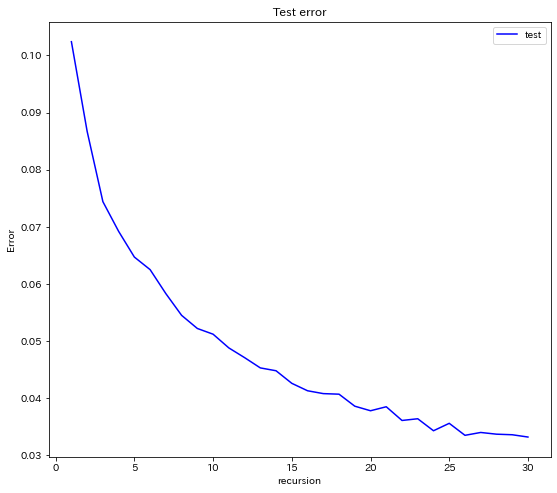

In [37]:
# test error

plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (9,8)
plt.plot(history[:,0], 1-history[:,4], 'b', label='test')
plt.xlabel('recursion')
plt.ylabel('Error')
plt.title('Test error')
plt.legend()
plt.show()